## Seleção de Patch de Maneira Dinâmica

In [1]:
from PIL import Image
import numpy as np
import random
random.seed(10)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# Realizando abertura da imagem com a bib PILLOW
path_image = "../data/base_recortada/ASC-H/10.png"
im = Image.open(path_image)
im.format, im.size, im.mode

('PNG', (180, 180), 'RGB')

In [3]:
# im = im.rotate(45)

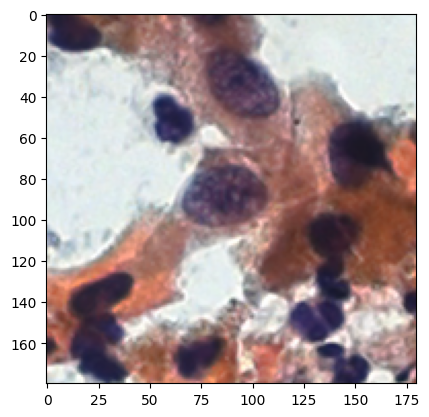

In [4]:
plt.imshow(im)
plt.show()

### Normal Pixels

In [7]:
def visualize_patch_centers(image, centers, patch_size):
    # cria o ax para plotar a img
    fig, ax = plt.subplots(1)
    
    # convert para np
    image_np = np.array(image)
    
    # normaliza a img para intervalo de 0 e 1
    if image_np.max() > 1:
        image_np = image_np / 255.0
    
    ax.imshow(image_np)
    
    patch_height, patch_width = patch_size
    
    for (h, w) in centers:
        rect = patches.Rectangle(
            (w - patch_width // 2, h - patch_height // 2), 
            patch_width, patch_height,
            linewidth=1, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        plt.plot(w, h, marker='v', color='r')
    
    # Ajusta limite das imagens para proporcao correta
    ax.set_xlim([0, image_np.shape[1]])
    ax.set_ylim([image_np.shape[0], 0])
    
    plt.show()

196
(8, 8)


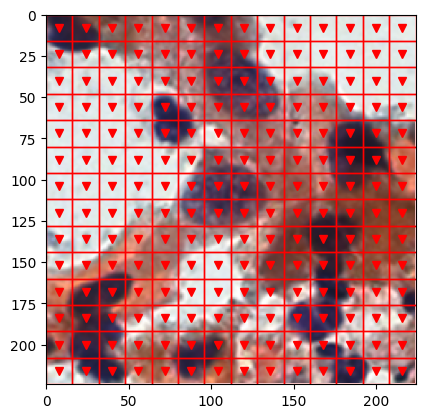

In [6]:
def generate_patch_centers(image_height, image_width, patch_size):
  
    # Stride é o espacamento entre os patches que é o próprio patch_size
    stride = patch_size  
    
    # Qtd de patches na height e no widget (SEM SOBREPOSICAO)
    num_patches_h = image_height // stride
    num_patches_w = image_width // stride
    
    centers_h = []
    centers_w = []
    
    # Todos os patches da coluna
    for i in range(num_patches_h):
      centers_h.append((i * stride + stride // 2))
    
    # Todos os patches da largura
    for j in range(num_patches_w):
      centers_w.append((j * stride + stride // 2))
    
    centers = []
    # Calculando a combinação das posicoes dos patches (X,Y)
    for h in centers_h:
      for w in centers_w:
        centers.append((h,w))
    
    # Retornar os pixels centrais
    return centers

# Variaveis
patch_size = 16
    
# Realizando resize na imagem com a bib PIL para 224x224
resized_image = im.resize((224,224))
centers = generate_patch_centers(224, 224, patch_size)
print(len(centers))
print(centers[0])

# Printa a visualizacao da imagem
visualize_patch_centers(resized_image, centers, (patch_size, patch_size))

-----

### Random Pixels

In [7]:
def generate_random_patch_centers(image_height, image_width, patch_size, num_patches):
    patch_height, patch_width = patch_size
    
    centers = []
    for _ in range(num_patches):
        h = random.uniform(patch_height / 2, image_height - patch_height / 2)
        w = random.uniform(patch_width / 2, image_width - patch_width / 2)
        centers.append((h, w))

    return centers

196
[(126.851739695502, 97.20892337242384), (128.24299063596985, 50.86843228501636), (177.17082028232255, 179.30648548695666), (143.92228705144456, 41.32774775591449), (116.29922680510431, 76.17674481739537), (59.99930875077128, 206.18591710234963), (215.28385444820668, 17.267727549690072), (186.91349575554852, 133.46364708138248), (87.37404507117651, 66.99258932459675), (148.39268820407085, 103.02087942012757), (150.6591889787157, 145.66403457088904), (35.659454100140266, 167.71026530035004), (212.3419557943277, 209.63273736422312), (135.57197867371548, 17.206211635841147), (8.843469984948753, 35.86628562621985), (203.72847245033347, 70.99499690204703), (84.1582851453687, 194.82481886415118), (73.38767143094174, 122.18829427458034), (98.69443918581743, 21.51878863438491), (129.58561494600147, 183.56612271367564), (40.53513502458053, 54.65418548669663), (93.87700320468687, 15.680372764194836), (111.29352771224202, 178.14043580136342), (144.8413152618947, 118.9646170157766), (185.866154

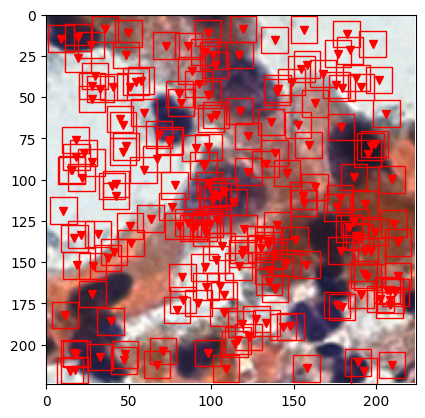

In [8]:
image_height = 224
image_width = 224
patch_size = (16, 16)
num_patches = 196
resized_image = im.resize((224,224))

patch_centers = generate_random_patch_centers(image_height, image_width, patch_size, num_patches)

# patch_centers = patch_centers[0:2]

print(len(patch_centers))
print(patch_centers)
visualize_patch_centers(resized_image, patch_centers, (16, 16))

---

In [8]:
import pickle
with open('../data/centros_pre_salvos/randomico_melhorado_identificador_por_imgname.pkl', 'rb') as f:
        lista_centro_dict  = pickle.load(f)

### Random Pixels (Melhorado)

In [ ]:
def pixels_adj(matriz, x, y, n_voltas):
    coords_voltas = []
    n_linhas, n_colunas = matriz.shape
    
    for volta in range(1, n_voltas + 1):
        for i in range(-volta, volta + 1):
            if 0 <= y + i < n_linhas:
                if 0 <= x - volta < n_colunas:
                    coords_voltas.append((y + i, x - volta))
                if 0 <= x + volta < n_colunas:
                    coords_voltas.append((y + i, x + volta))
        
        for j in range(-volta + 1, volta):
            if 0 <= x + j < n_colunas:
                if 0 <= y - volta < n_linhas:
                    coords_voltas.append((y - volta, x + j))
                if 0 <= y + volta < n_linhas:
                    coords_voltas.append((y + volta, x + j))
    coords_voltas.append((y,x))
    return coords_voltas

def verificar_adj(matriz, x, y, lista_centros):
    x, y = int(round(x)), int(round(y))  # Converta para inteiros
    if len(lista_centros) == 0:
        return False
    else:
        for each in lista_centros:
            each_x, each_y = int(round(each[1])), int(round(each[0]))
            ret = pixels_adj(matriz=matriz, x=each_x, y=each_y, n_voltas=8)
            if (y, x) in ret:  # Verifique na ordem correta
                return True
    return False

def random_patchs_melhorados(image_height, image_width, patch_size, num_patches, img_PIL):
    patch_height, patch_width = patch_size
    
    img_gray = img_PIL.convert('L')
    img_mtx = np.array(img_gray)
    
    centers = []
    
    for _ in range(num_patches):
        h = random.uniform(patch_height / 2, image_height - patch_height / 2)
        w = random.uniform(patch_width / 2, image_width - patch_width / 2)
        
        
        check = verificar_adj(img_mtx, w, h, centers)
        
        while check:
            h = random.uniform(patch_height / 2, image_height - patch_height / 2)
            w = random.uniform(patch_width / 2, image_width - patch_width / 2)
            check = verificar_adj(img_mtx, w, h, centers)
        
        centers.append((h, w))
    
    return centers

# Uso do código
image_height = 224
image_width = 224
patch_size = (16, 16)
num_patches = 196
imagem_rgb = im.convert('RGB')
resized_image = imagem_rgb.resize((224, 224))

patch_centers = random_patchs_melhorados(image_height, image_width, patch_size, num_patches, resized_image)

print(len(patch_centers))
print(patch_centers)
visualize_patch_centers(resized_image, patch_centers, (16, 16))

### Geração dos centros pré-treinamento

In [2]:
import random
import numpy as np
import cv2
from PIL import Image

####################################
# Random Pixels Melhorado
####################################
def pixels_adj( matriz, x, y, n_voltas):
  coords_voltas = []
  n_linhas, n_colunas = matriz.shape
  
  for volta in range(1, n_voltas + 1):
      for i in range(-volta, volta + 1):
          if 0 <= y + i < n_linhas:
              if 0 <= x - volta < n_colunas:
                  coords_voltas.append((y + i, x - volta))
              if 0 <= x + volta < n_colunas:
                  coords_voltas.append((y + i, x + volta))
      
      for j in range(-volta + 1, volta):
          if 0 <= x + j < n_colunas:
              if 0 <= y - volta < n_linhas:
                  coords_voltas.append((y - volta, x + j))
              if 0 <= y + volta < n_linhas:
                  coords_voltas.append((y + volta, x + j))
  coords_voltas.append((y,x))
  return coords_voltas

def verificar_adj(matriz, x, y, lista_centros):
    x, y = int(round(x)), int(round(y))
    if len(lista_centros) == 0:
        return False
    else:
        for each in lista_centros:
            each_x, each_y = int(round(each[1])), int(round(each[0]))
            ret = pixels_adj(matriz=matriz, x=each_x, y=each_y, n_voltas=8)
            if (y, x) in ret:  
                return True
    return False

def random_patchs_melhorados( patch_size, num_patches, imagem_tensor):
  
    img_PIL = Image.fromarray((imagem_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))

    image_height, image_width = img_PIL.size
    
    patch_height, patch_width = patch_size
    
    img_gray = img_PIL.convert('L')
    img_mtx = np.array(img_gray)
    
    centers = []
    
    for _ in range(num_patches):
        h = random.uniform(patch_height / 2, image_height - patch_height / 2)
        w = random.uniform(patch_width / 2, image_width - patch_width / 2)
        
        
        check = verificar_adj(img_mtx, w, h, centers)
        
        while check:
            h = random.uniform(patch_height / 2, image_height - patch_height / 2)
            w = random.uniform(patch_width / 2, image_width - patch_width / 2)
            check = verificar_adj(img_mtx, w, h, centers)
        
        centers.append((h, w))
    
    print(len(centers))
    
    return centers

In [4]:
import os
from torchvision.datasets import ImageFolder

class CustomImageFolder(ImageFolder):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)

        path = self.imgs[index][0]

        image_name = os.path.basename(path)

        return img, target, image_name 

49
O Nome da imagem é: 10.png
49
[(104.462409038501, 45.49218455986384), (31.086644520282988, 116.78061386366936), (43.03121056590592, 36.06918554841011), (39.113870078702625, 151.43582909342734), (170.87783432193493, 171.47408676649167), (126.55221737813449, 137.95976629229386), (160.70822980519205, 98.10933572136247), (113.87376424684854, 152.90474470998237), (137.7061439370295, 132.89312657403798), (140.0914433636069, 118.83059360689722), (57.07236215586335, 74.71347216662745), (148.72944904603727, 96.43049929272186), (180.81820634878383, 87.83141496114578), (144.5159230851661, 38.1888773123989), (73.51136130928558, 179.40890426210476), (49.70426498057349, 136.17535801994129), (21.333503822518963, 132.98300002194458), (102.6731262059398, 188.68461279943307), (81.02908540725525, 144.45645065688183), (45.71556145163597, 110.03654230658951), (90.75918936699065, 106.17464499752484), (68.6256775595487, 56.65017294116216), (115.81139233604006, 141.49513811234573), (124.05136361456664, 198

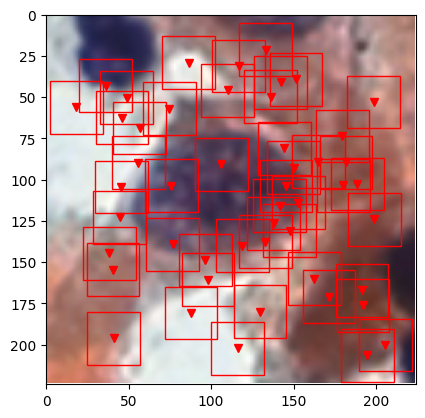

49
O Nome da imagem é: 10000.png
49
[(80.12073464263165, 129.10123432978722), (45.75041731769962, 109.04030811794763), (84.26884890799846, 16.9426846393184), (145.44551176085974, 112.29008612279182), (165.0343771438361, 184.3558033777214), (25.22334061601446, 153.10843126840845), (104.18341088831068, 183.8545882578273), (38.17746385259627, 177.04536736207766), (98.48411415699371, 33.79800050831758), (30.09961722342654, 88.71607904142), (31.380051071019537, 17.355037002911033), (174.72505530038458, 121.74264182076311), (125.57245323613411, 188.66237430311534), (32.31719697212354, 197.3132569063767), (172.5210412322179, 91.60998568048423), (20.452725091719557, 207.52662867370552), (137.51787791463389, 152.64207624402587), (149.5626755994952, 73.36002764019631), (142.12576220780022, 102.54602885234227), (59.54265709734623, 111.91109739179173), (105.8085537961102, 73.97083373957307), (130.8258267779996, 20.45356488340441), (120.53333478105446, 137.1255889485713), (172.5747200927394, 74.258

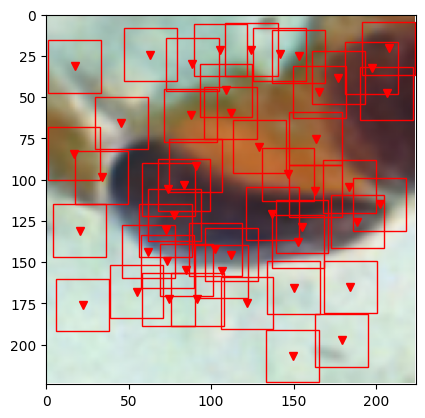

In [9]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import pickle
import numpy as np

pickle_file = "../data/centros_pre_salvos/randomico_melhorado.pkl"

img_size = (224, 224)
batch_size = 32

transform = v2.Compose([
    v2.Resize(img_size),
    v2.ToTensor(),
])

dataset = CustomImageFolder(root="../data/base_recortada/", transform=transform)


# lista_centro_dict = []

centros_dict = {}

# Iteração sobre as imagens do dataset
for img_idx in range(2):
    image, label, image_name = dataset[img_idx]  # Carrega a imagem e o rótulo

    centers = random_patchs_melhorados( patch_size=(32,32), num_patches=49, imagem_tensor=image)
    
    
    centros_dict[image_name] = centers
    
    
    im = Image.fromarray((image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))
    
    imagem_rgb = im.convert('RGB')
    resized_image = imagem_rgb.resize((224, 224))
    print(f"O Nome da imagem é: {image_name}")
    print(len(centers))
    print(centers)
    visualize_patch_centers(resized_image, centers, (32, 32))
    
# Salvando o dicionário em um arquivo pickle
# with open(pickle_file, 'wb') as f:
#     pickle.dump(centros_dict, f)

# print(f"Centros dos patches salvos em {pickle_file}")

In [11]:
centros_dict

{'10.png': [(112.07574872909235, 144.72014423109937),
  (138.17469415157353, 75.71967072775143),
  (65.2317932597663, 18.90211342854712),
  (149.42224442939477, 67.1075030541324),
  (172.13178068882692, 145.69977453805512),
  (133.672942694691, 198.95495324995935),
  (15.957016688605174, 200.33019360386234),
  (75.70670145620515, 204.96138560528024),
  (17.058190895637416, 78.42829487910873),
  (94.8034526335565, 153.20524668920453),
  (135.2965660752905, 61.9714452266923),
  (90.02522199309969, 47.206425138826),
  (10.643626853933915, 53.03776767774817),
  (69.29513639917113, 184.6358429778094),
  (66.80959302491993, 88.39465853570718),
  (180.45717397479513, 171.2571824221338),
  (214.3975572125142, 11.184509366668173),
  (191.43347606161984, 150.19656801187634),
  (165.65770937619973, 188.85631650297978),
  (26.75107544273341, 142.29123949537092),
  (197.48082491213648, 83.23638570463329),
  (90.08201234617958, 137.4175447345632),
  (168.4921804919085, 51.99270445678919),
  (105.710

### Fazendo verificação se está mantendo os centros

In [14]:
import pickle
with open('../data/centros_pre_salvos/randomico_melhorado_identificador_por_imgname.pkl', 'rb') as f:
        lista_centro_dict  = pickle.load(f)

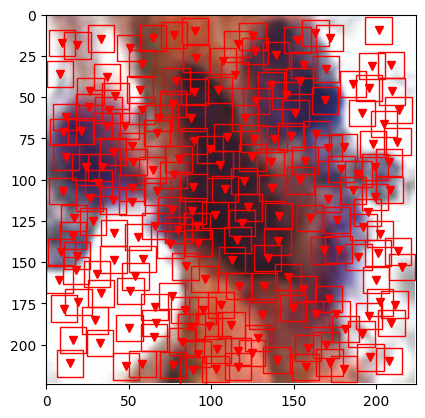

In [26]:
path_image = "../data/base_treinamento/train/SCC/augmentation_id_93_568.png"
im = Image.open(path_image)
im.format, im.size, im.mode
imagem_rgb = im.convert('RGB')
resized_image = imagem_rgb.resize((224, 224))

patch_centers = lista_centro_dict["augmentation_id_93_568.png"]

visualize_patch_centers(resized_image, patch_centers, (16, 16))